### Set up google colab enviroment

In [6]:
from keras.optimizers import RMSprop
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, ZeroPadding2D, Add
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras import Sequential
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.model_selection import train_test_split
import cv2
import random
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


### Set up user-defined functions

In [0]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
    
    return data

In [0]:
def get_result(prediction):
    img_list = []
    for img in test_images:
        img_list.append(int(img.split('/')[-1].split('.')[0]))
    
    result = []
    for i in range(len(img_list)):
        result.append((img_list[i],prediction[i][0]))
        
    col_name = ['id','label']
    df = pd.DataFrame(result, columns = col_name).sort_values(by = 'id')
    return df

### Loading Pictures

In [0]:
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

ROWS = 64
COLS = 64
CHANNELS = 3

# my laptop hidder file. Contain the words 'DS'
train_images = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR)]
test_images = [TEST_DIR + i for i in os.listdir(TEST_DIR)]
random.shuffle(test_images)
random.shuffle(train_images)

In [0]:
train = prep_data(train_images)
test = prep_data(test_images)

# print the image shape
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (25000, 3, 64, 64)
Test shape: (12500, 3, 64, 64)


Text(0.5, 1.0, 'Cats and Dogs')

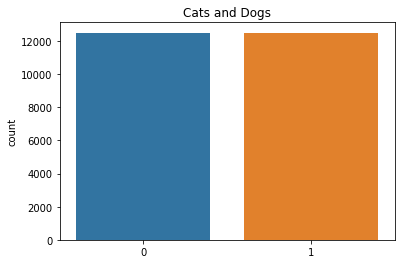

In [0]:
labels = [1 if 'dog' in i else 0 for i in train_images]
sns.countplot(labels)
plt.title('Cats and Dogs')

### Start Training

Establish my baseline model

In [0]:
def my_Conv2D_network(optimize):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(3),data_format='channels_first'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid')) # 2 because we have cat and dog classes

    model.compile(loss='binary_crossentropy', optimizer= optimize, metrics=['accuracy'])

    return model
# model.summary()

In [0]:
model = my_Conv2D_network('rmsprop')

In [0]:
earlystop = EarlyStopping(patience=3)
model.fit(train, labels, batch_size= 200, epochs = 20,
          validation_split=0.3, verbose=0, shuffle=True, callbacks=[early_stopping])

In [0]:
predictions = model.predict(test)

In [0]:
df = get_result(predictions)
df.to_csv('sample_result_rmsp.csv', index = False)

My convolutional neural network gives me a **Logloss** of 0.46234

The above method didn't try to do image normalization. All the images are colored images so that they need divided by 255 which is the total number of RGB encoder. So in the following steps, I tried normalized training data

In [0]:
train_255 = train / 255
test_255 = test / 255

In [0]:
model = my_Conv2D_network('rmsprop')

In [0]:
earlystop = EarlyStopping(patience = 3)
model.fit(train_255, labels, batch_size= 200, epochs = 20,
              validation_split=0.3, verbose=0, shuffle=True, callbacks=[early_stopping])

In [0]:
predictions2 = model.predict(test_255)

In [0]:
df = get_result(predictions2)
df.to_csv('sample_result_rmsp_255.csv', index = False)

Only changing the training data, the same hyper-parameter settings of my convolutional neural network gives me a **Logloss** of 0.51420, which is higher than the previous one.

Here, let's try adam optimizer

In [0]:
model = my_Conv2D_network('adam')

In [0]:
earlystop = EarlyStopping(patience = 3)
model.fit(train255, label, batch_size= 200, epochs = 20,
              validation_split=0.3, verbose=0, shuffle=True, callbacks=[early_stopping])

In [0]:
predictions3 = model.predict(test_255)

In [0]:
df = get_result(predictions3)
df.to_csv('sample_result_adam_255.csv', index = False)

Only changing the optimizer to adam, the same hyper-parameter settings of my convolutional neural network gives me a Logloss of 0.47716, which is higher than the previous one.

### Try Deep Neural Network

And then, I tried some deep neural networks.

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.applications import VGG16,VGG19
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.models import Sequential,Model,load_model
from keras.optimizers import SGD, Adam, RMSprop
K.set_image_data_format('channels_first') # use ' rather than ""
from keras.callbacks import EarlyStopping

In [0]:
def my_network(my_model,dropout,bsize):
  x = my_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(dropout)(x)
  predictions = Dense(1, activation= 'sigmoid')(x)
  model = Model(inputs = my_model.input, outputs = predictions)
  # sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
  adam = Adam(lr=0.0001)
  # adam = Adam(lr=0.00005)
  model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['acc'])
  early_stopping = EarlyStopping(patience=5,monitor='loss')
  model.fit(train, labels, epochs = 20, batch_size = 128 , callbacks=[early_stopping])
  return model

#### VGG 16

Below, I am tring different hyparameter seetings with **VGG16** models.

Here is the summary:
with my basic model

* droppout rate = 0.2, batch size = 128, epochs = 20, log_loss = 0.56050
* droppout rate = 0.3, batch size = 128, epochs = 20, log_loss = 0.65193
* droppout rate = 0.1, batch size = 128, epochs = 20, log_loss = 0.80925
* droppout rate = 0.6, batch size = 128, epochs = 20, log_loss = 0.80039
* droppout rate = 0.2, batch size = 64, epochs = 20, log_loss = 0.60747

In [0]:
vgg16 = VGG16(weights= None, include_top=False, input_shape= (3,64,64))
vgg16_model = my_network(vgg16,0.2,128)
prediction_vgg16 = vgg16_model.predict(test)
df = get_result(prediction_vgg16)
df.to_csv('/content/drive/My Drive/6420 Predictive Analytics/HOMEWORK/HW4/vgg16.csv', index = False)

In [0]:
vgg16 = VGG16(weights= None, include_top=False, input_shape= (3,64,64))
vgg16_model = my_network(vgg16,0.3,128)
prediction_vgg16 = vgg16_model.predict(test)
df = get_result(prediction_vgg16)
df.to_csv('/content/drive/My Drive/6420 Predictive Analytics/HOMEWORK/HW4/vgg16_v2.csv', index = False)

In [0]:
vgg16 = VGG16(weights= None, include_top=False, input_shape= (3,64,64))
vgg16_model = my_network(vgg16,0.1,128)
prediction_vgg16 = vgg16_model.predict(test)
df = get_result(prediction_vgg16)
df.to_csv('/content/drive/My Drive/6420 Predictive Analytics/HOMEWORK/HW4/vgg16_v3.csv', index = False)

In [0]:
vgg16 = VGG16(weights= None, include_top=False, input_shape= (3,64,64))
vgg16_model = my_network(vgg16,0.6,128)
prediction_vgg16 = vgg16_model.predict(test)
df = get_result(prediction_vgg16)
df.to_csv('/content/drive/My Drive/6420 Predictive Analytics/HOMEWORK/HW4/vgg16_v4.csv', index = False)

In [0]:
vgg16 = VGG16(weights= None, include_top=False, input_shape= (3,64,64))
vgg16_model = my_network(vgg16,0.2,64)
prediction_vgg16 = vgg16_model.predict(test)
df = get_result(prediction_vgg16)
df.to_csv('/content/drive/My Drive/6420 Predictive Analytics/HOMEWORK/HW4/vgg16_v5.csv', index = False)

#### VGG19

And the VGG19 only returns me 0.8 logloss so that I don't think VGG19 can do better in this situation. I just trained once.

In [0]:
vgg19 = VGG19(weights= None, include_top=False, input_shape= (3,64,64))
vgg19_model = my_network(vgg19,0.2,128)
prediction_vgg19 = vgg19_model.predict(test)
df = get_result(prediction_vgg19)
df.to_csv('/content/drive/My Drive/6420 Predictive Analytics/HOMEWORK/HW4/vgg19_v2.csv', index = False)

#### Resnet 50

Finally , I tries resnet50 with a logloss greater than 1

In [0]:
ResNet50 = ResNet50(weights= None, include_top=False, input_shape= (3,224,224))
ResNet50_model = my_network(ResNet50,0.2,128)
prediction_resnet50 = resnet_model.predict(test)
df = get_result(prediction_resnet50)
df.to_csv('/content/drive/My Drive/6420 Predictive Analytics/HOMEWORK/HW4/resnet.csv', index = False)